In [21]:
# Import summarize from gensim
from gensim.summarization.summarizer import summarize
from gensim.summarization import keywords# Import the library
# to convert MSword doc to txt for processing.
import docx2txt

In [22]:

import PyPDF2
import os
from os import listdir
from os.path import isfile, join
from io import StringIO
import pandas as pd
from collections import Counter
import en_core_web_sm
nlp = en_core_web_sm.load()
from spacy.matcher import PhraseMatcher

In [23]:

#Function to read resumes from the folder one by one
mypath='C:/Users/hp/Desktop/prjpfe/CV' #enter your path here where you saved the resumes
onlyfiles = [os.path.join(mypath, f) for f in os.listdir(mypath) if os.path.isfile(os.path.join(mypath, f))]

def pdfextract(file):
    fileReader = PyPDF2.PdfFileReader(open(file,'rb'))
    countpage = fileReader.getNumPages()
    count = 0
    text = []
    while count < countpage:    
        pageObj = fileReader.getPage(count)
        count +=1
        t = pageObj.extractText()
        #print (t)
        text.append(t)
    return text

In [24]:
def create_profile(file):
    text = pdfextract(file) 
    text = str(text)
    text = text.replace("\\n", "")
    text = text.lower()
    #below is the csv where we have all the keywords, you can customize your own
    keyword_dict = pd.read_csv('template_new.csv',sep=";")
    stats_words = [nlp(text) for text in keyword_dict['Statistics'].dropna(axis = 0)]
    NLP_words = [nlp(text) for text in keyword_dict['NLP'].dropna(axis = 0)]
    ML_words = [nlp(text) for text in keyword_dict['Machine Learning'].dropna(axis = 0)]
    DL_words = [nlp(text) for text in keyword_dict['Deep Learning'].dropna(axis = 0)]
    R_words = [nlp(text) for text in keyword_dict['R Language'].dropna(axis = 0)]
    python_words = [nlp(text) for text in keyword_dict['Python Language'].dropna(axis = 0)]
    Data_Engineering_words = [nlp(text) for text in keyword_dict['Data Engineering'].dropna(axis = 0)]

    matcher = PhraseMatcher(nlp.vocab)
    matcher.add('Stats', None, *stats_words)
    matcher.add('NLP', None, *NLP_words)
    matcher.add('ML', None, *ML_words)
    matcher.add('DL', None, *DL_words)
    matcher.add('R', None, *R_words)
    matcher.add('Python', None, *python_words)
    matcher.add('DE', None, *Data_Engineering_words)
    doc = nlp(text)
    
    d = []  
    matches = matcher(doc)
    for match_id, start, end in matches:
        rule_id = nlp.vocab.strings[match_id]  # get the unicode ID, i.e. 'COLOR'
        span = doc[start : end]  # get the matched slice of the doc
        d.append((rule_id, span.text))      
    keywords = "\n".join(f'{i[0]} {i[1]} ({j})' for i,j in Counter(d).items())
    
    ## convertimg string of keywords to dataframe
    df = pd.read_csv(StringIO(keywords),names = ['Keywords_List'])
    df1 = pd.DataFrame(df.Keywords_List.str.split(' ',1).tolist(),columns = ['Subject','Keyword'])
    df2 = pd.DataFrame(df1.Keyword.str.split('(',1).tolist(),columns = ['Keyword', 'Count'])
    df3 = pd.concat([df1['Subject'],df2['Keyword'], df2['Count']], axis =1) 
    df3['Count'] = df3['Count'].apply(lambda x: x.rstrip(")"))
    
    base = os.path.basename(file)
    filename = os.path.splitext(base)[0]
       
    name = filename.split('_')
    name2 = name[0]
    name2 = name2.lower()
    ## converting str to dataframe
    name3 = pd.read_csv(StringIO(name2),names = ['Candidate Name'])
    
    dataf = pd.concat([name3['Candidate Name'], df3['Subject'], df3['Keyword'], df3['Count']], axis = 1)
    dataf['Candidate Name'].fillna(dataf['Candidate Name'].iloc[0], inplace = True)

    return(dataf)
        

In [25]:
final_database=pd.DataFrame()
i = 0 
while i < len(onlyfiles):
    file = onlyfiles[i]
    dat = create_profile(file)
    final_database = final_database.append(dat)
    i +=1

In [26]:
final_database2 = final_database['Keyword'].groupby([final_database['Candidate Name'], final_database['Subject']]).count().unstack()

In [27]:
final_database2

Subject,DE,DL,ML,NLP,Python,R,Stats
Candidate Name,,,,,,,
edward,7.0,10.0,11.0,10.0,10.0,4.0,5.0
emna,1.0,NaN,NaN,NaN,NaN,NaN,NaN
hamza,1.0,3.0,NaN,1.0,1.0,NaN,NaN
helmi,1.0,NaN,NaN,1.0,1.0,NaN,NaN
rmy,1.0,3.0,NaN,1.0,1.0,NaN,NaN


In [28]:
final_database2.reset_index(inplace = True)
final_database2.fillna(0,inplace=True)
new_data = final_database2.iloc[:,1:]
new_data.index = final_database2['Candidate Name']

In [29]:
new_data 

Subject,DE,DL,ML,NLP,Python,R,Stats
Candidate Name,,,,,,,
edward,7.0,10.0,11.0,10.0,10.0,4.0,5.0
emna,1.0,0.0,0.0,0.0,0.0,0.0,0.0
hamza,1.0,3.0,0.0,1.0,1.0,0.0,0.0
helmi,1.0,0.0,0.0,1.0,1.0,0.0,0.0
rmy,1.0,3.0,0.0,1.0,1.0,0.0,0.0


In [30]:
liste=[]
for i,j in new_data.iterrows():
    liste.append(i)

print(liste)


['edward', 'emna', 'hamza', 'helmi', 'rmy']


In [31]:
x=new_data.values

In [32]:
x

array([[ 7., 10., 11., 10., 10.,  4.,  5.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  3.,  0.,  1.,  1.,  0.,  0.],
       [ 1.,  0.,  0.,  1.,  1.,  0.,  0.],
       [ 1.,  3.,  0.,  1.,  1.,  0.,  0.]])

In [33]:
skills=x.tolist()
skills

[[7.0, 10.0, 11.0, 10.0, 10.0, 4.0, 5.0],
 [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 3.0, 0.0, 1.0, 1.0, 0.0, 0.0],
 [1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0],
 [1.0, 3.0, 0.0, 1.0, 1.0, 0.0, 0.0]]

In [34]:
liste_finale=list(zip(liste,skills))

In [35]:
liste_finale

[('edward', [7.0, 10.0, 11.0, 10.0, 10.0, 4.0, 5.0]),
 ('emna', [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]),
 ('hamza', [1.0, 3.0, 0.0, 1.0, 1.0, 0.0, 0.0]),
 ('helmi', [1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0]),
 ('rmy', [1.0, 3.0, 0.0, 1.0, 1.0, 0.0, 0.0])]

In [36]:
liste_f=list()
for i,j in liste_finale:
    liste_f.append((i,sum(j)))

liste_f

[('edward', 57.0), ('emna', 1.0), ('hamza', 6.0), ('helmi', 3.0), ('rmy', 6.0)]

In [37]:
import pandas as pd
feature = pd.read_csv("C:/Users/hp/Desktop/prjpfe/SpacyResume/template_new.csv", sep=";")


In [38]:

liste_stat=[]
indices=["Statistics","Machine Learning","Deep Learning","R Language","Python Language","NLP","Data Engineering"]
liste2=[]
for i in indices:
    feature[i]
    liste=feature[i].values
    #liste_stat.append(feature["Statistics"].values)
    x=liste.tolist()
    liste2.append(x)
liste3=[]
for j in liste2:
    for y in j:
        if type(y)!=float:
            liste3.append(y)
print(len(liste3))

63


In [39]:
for i,j in liste_f:
    print( str(i)+"'s resume matches about "+ str((float(int(j)/len(liste3))*100))+ "% of the job description.")

edward's resume matches about 90.47619047619048% of the job description.
emna's resume matches about 1.5873015873015872% of the job description.
hamza's resume matches about 9.523809523809524% of the job description.
helmi's resume matches about 4.761904761904762% of the job description.
rmy's resume matches about 9.523809523809524% of the job description.


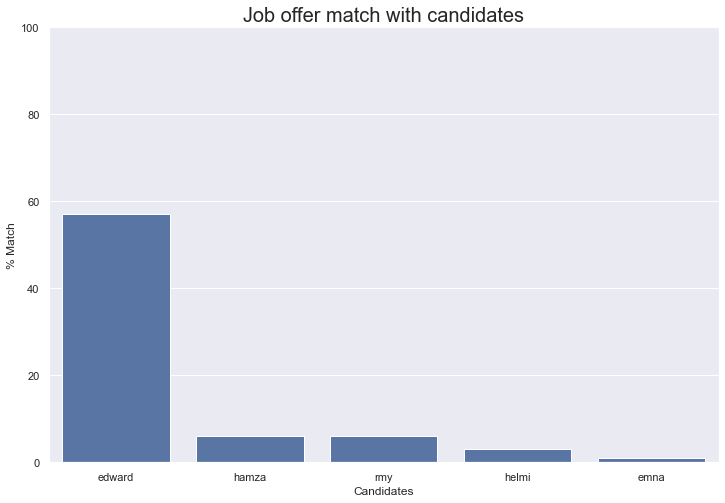

In [40]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Sort tuples from high to low on match percentage
liste_f.sort(key=lambda tup: tup[1], reverse=True)

# Unpack tuples
names, pct = zip(*liste_f)

# Plotting
sns.set_theme(style='darkgrid')

fig, ax = plt.subplots(figsize=(12,8))
ax.set_title('Job offer match with candidates', fontsize=20)
ax.set(xlabel='Candidates', ylabel='% Match')
ax.set(ylim=(0, 100))


sns.set(font_scale=1.5)
sns.barplot(x=list(names), y=list(pct), color='b')

plt.show()